In [2]:
# Import packages  

import pandas as pd
import numpy as np# Import packages 
import nltk
from nltk import FreqDist
import pandas as pd 
import itertools
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import gensim
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import gensim

[nltk_data] Downloading package stopwords to /Users/lucia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/lucia/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [13]:
# Import file 
df = pd.read_csv("DisneylandReviews.csv",encoding='iso-8859-1', na_values='missing')
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


# Data Preprocessing 

Remove duplicated rows

In [14]:
#checking duplicated
df[df['Review_ID'].isin(df['Review_ID'][df['Review_ID'].duplicated()])].sort_values('Review_ID')

# drop duplicate
df.drop_duplicates('Review_ID', inplace=True, keep='first')

Get year and Month 

In [15]:
# new data frame with split value columns 
new = df["Year_Month"].str.split("-", n = 1, expand = True) 

# making separate year column from new data frame 
df["year"]= new[0] 
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)  
    
# making separate month column from new data frame 
df["month"]= new[1] 
df['month'] = pd.to_numeric(df['month'], errors='coerce')
df = df.dropna(subset=['month'])
df['month'] = df['month'].astype(int)

# Dropping old feature  
df.drop(columns =["Year_Month"], inplace = True) 


Data cleaning 

In [16]:
#==
features = df['Review_Text'].values
#=== 
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the Http: urls
    processed_feature = re.sub('(https?://\S+)', '', str(features[sentence]))
    
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', processed_feature)

    # Remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)


In [17]:
df['reviews']=processed_features
df

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,year,month,reviews
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,if you ve ever been to disneyland anywhere you...
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,its been while since last time we visit hk dis...
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,thanks god it wasn too hot or too humid when w...
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,hk disneyland is great compact park unfortunat...
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,the location is not in the city took around 1 ...
...,...,...,...,...,...,...,...,...
42113,92198076,4,United Kingdom,Although our pick up was prompt the taxi drive...,Disneyland_Paris,2011,1,although our pick up was prompt the taxi drive...
42114,92061774,4,Germany,Just returned from a 4 days family trip to Dis...,Disneyland_Paris,2011,1,just returned from 4 days family trip to disne...
42115,91995748,1,United Kingdom,We spent the 20 Dec 2010 in the Disney park an...,Disneyland_Paris,2010,12,we spent the 20 dec 2010 in the disney park an...
42116,91984642,2,United Kingdom,Well I was really looking forward to this trip...,Disneyland_Paris,2010,12,well was really looking forward to this trip o...


review score 

In [18]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['reviews'].apply(getSubjectivity)
df['Polarity'] = df['reviews'].apply(getPolarity)


def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'


In [19]:
df['Analysis'] = df['Polarity'].apply(getAnalysis)
df['sentiment']=df['Analysis']
df['Sentiment']=df['Rating'].apply(lambda x:'Negative' if x<3 else np.nan)
df['Sentiment']=df['Sentiment'].fillna(df['sentiment'])

df

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,year,month,reviews,Subjectivity,Polarity,Analysis,sentiment,Sentiment
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,if you ve ever been to disneyland anywhere you...,0.561481,0.239352,Positive,Positive,Positive
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,its been while since last time we visit hk dis...,0.459783,0.205797,Positive,Positive,Positive
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,thanks god it wasn too hot or too humid when w...,0.434857,0.119238,Positive,Positive,Positive
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,hk disneyland is great compact park unfortunat...,0.512143,0.189286,Positive,Positive,Positive
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,the location is not in the city took around 1 ...,0.437500,0.266667,Positive,Positive,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42113,92198076,4,United Kingdom,Although our pick up was prompt the taxi drive...,Disneyland_Paris,2011,1,although our pick up was prompt the taxi drive...,0.470556,0.034402,Positive,Positive,Positive
42114,92061774,4,Germany,Just returned from a 4 days family trip to Dis...,Disneyland_Paris,2011,1,just returned from 4 days family trip to disne...,0.437991,0.202937,Positive,Positive,Positive
42115,91995748,1,United Kingdom,We spent the 20 Dec 2010 in the Disney park an...,Disneyland_Paris,2010,12,we spent the 20 dec 2010 in the disney park an...,0.493521,0.020628,Positive,Positive,Negative
42116,91984642,2,United Kingdom,Well I was really looking forward to this trip...,Disneyland_Paris,2010,12,well was really looking forward to this trip o...,0.497893,0.125890,Positive,Positive,Negative


In [20]:
#====
df=df.drop(['sentiment','Analysis'],axis=1)
df

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,year,month,reviews,Subjectivity,Polarity,Sentiment
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,if you ve ever been to disneyland anywhere you...,0.561481,0.239352,Positive
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,its been while since last time we visit hk dis...,0.459783,0.205797,Positive
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,thanks god it wasn too hot or too humid when w...,0.434857,0.119238,Positive
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,hk disneyland is great compact park unfortunat...,0.512143,0.189286,Positive
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,the location is not in the city took around 1 ...,0.437500,0.266667,Positive
...,...,...,...,...,...,...,...,...,...,...,...
42113,92198076,4,United Kingdom,Although our pick up was prompt the taxi drive...,Disneyland_Paris,2011,1,although our pick up was prompt the taxi drive...,0.470556,0.034402,Positive
42114,92061774,4,Germany,Just returned from a 4 days family trip to Dis...,Disneyland_Paris,2011,1,just returned from 4 days family trip to disne...,0.437991,0.202937,Positive
42115,91995748,1,United Kingdom,We spent the 20 Dec 2010 in the Disney park an...,Disneyland_Paris,2010,12,we spent the 20 dec 2010 in the disney park an...,0.493521,0.020628,Negative
42116,91984642,2,United Kingdom,Well I was really looking forward to this trip...,Disneyland_Paris,2010,12,well was really looking forward to this trip o...,0.497893,0.125890,Negative


# Explorative Analysis 

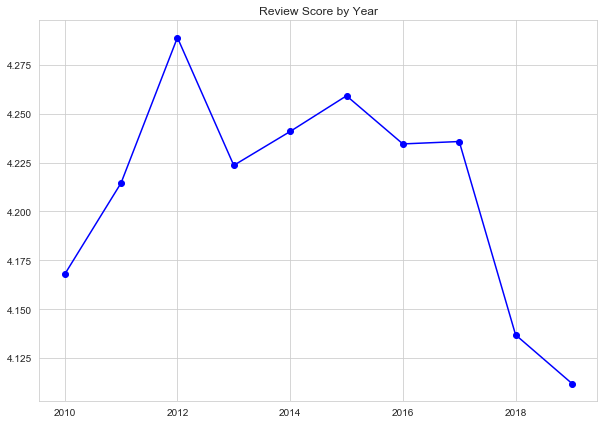

In [11]:
import seaborn as sns
sns.set_style("whitegrid")
#== 
df2=df.groupby('year',as_index=False).agg({'Rating':'mean'})
plt.figure(figsize=(10,7))
plt.plot(df2['year'] ,df2['Rating'],marker='o',color='blue')
plt.title('Review Score by Year')
plt.show()


Trend of rating by year

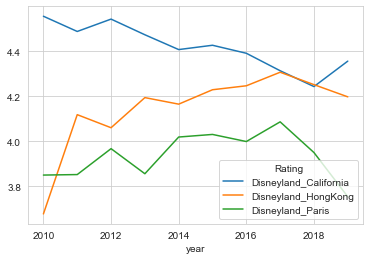

In [22]:

a  = df.groupby(['year','Branch']).Rating.mean()

# unstack the `continent` index, to place it as columns
a = a.unstack(level='Branch')

# The name of columns would become the name of legend
# when using dataframe plot
a.columns.name = 'Rating'




a.plot()

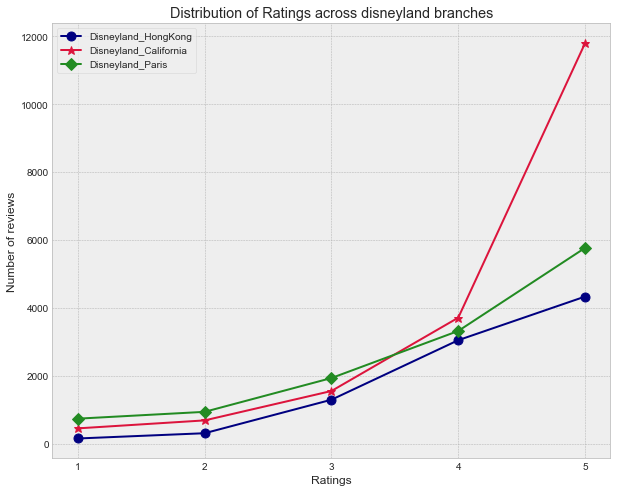

In [186]:
branch_col = ['navy', 'crimson', 'forestgreen']
markers = ['o', '*', 'D']
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 8))
    for branch, m, col in zip(df.Branch.unique(), markers, branch_col):
        counts = df[df.Branch == branch]['Rating'].value_counts()
        x = counts.index
        y = counts.values
        plt.plot(x, y, marker=m, markersize=9, color=col, label=branch)
        plt.xticks(np.arange(1, 6))
        plt.xlabel('Ratings')
        plt.ylabel('Number of reviews')
    plt.title('Distribution of Ratings across disneyland branches')
    plt.legend()
    plt.show()

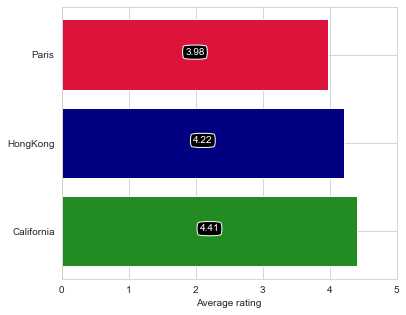

In [176]:
branch_ratings = df.groupby('Branch').agg({'Rating': 'mean'}).unstack()['Rating']
plt.figure(figsize=(6, 5))
plt.barh([branch[11:] for branch in branch_ratings.index], 
         branch_ratings.values, 
         color=['forestgreen', 'navy', 'crimson'])
for val, p in zip(branch_ratings.values, [branch[11:] for branch in branch_ratings.index]):
    plt.text(val/2, p, round(val, 2), color='white', ha='center', 
            bbox=dict(boxstyle='round4', facecolor='black'))
plt.xlabel('Average rating')
plt.xticks(np.arange(0, 6))
plt.show()

Wordcloud-- Positive Reviews

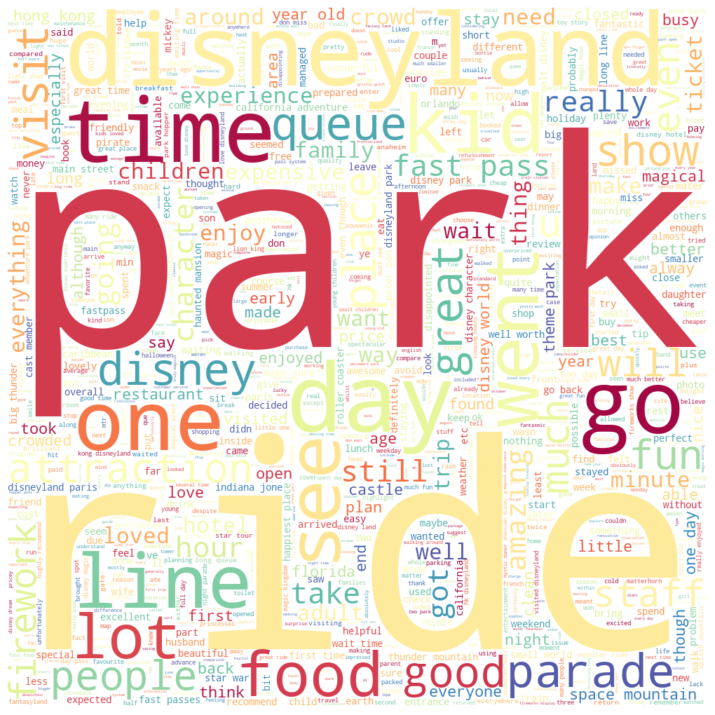

In [50]:
df_like=df.loc[df['Sentiment']=='Positive']
#===
Reviews_Text = " ".join(insul for insul in df_like.reviews)


#== 
wc = WordCloud(background_color='white', mode='RGB',
               width=1000, max_words=1000, height=1000,
               random_state=1, contour_width=1, contour_color='green',colormap='Spectral')
wc.generate(Reviews_Text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

Negative reviews

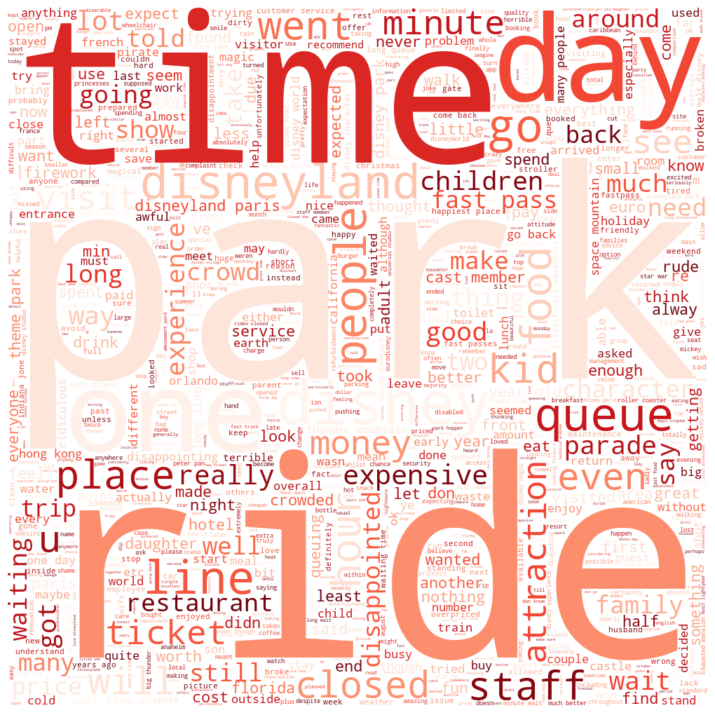

In [26]:
df_dislike=df.loc[df['Sentiment']=='Negative']
#===
Reviews_Text = " ".join(insul for insul in df_dislike.reviews)

#== 
wc = WordCloud(background_color='white', mode='RGB',
               width=1000, max_words=1000, height=1000,
               random_state=1, contour_width=1, contour_color='red',colormap='Reds')
wc.generate(Reviews_Text)
plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

# Topic Modeling -LDA

# What are the most important features in the positive and negative reviews? 

Positive Review 

In [51]:
#Stopwords Removal and only keep text data then change to lowercase
mystopwords = stopwords.words('english')
newStopWords = ['park','disney','parks','disneyland','disney']
mystopwords.extend(newStopWords)


In [112]:
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words=mystopwords)
doc_term_matrix = count_vect.fit_transform(df_like['reviews'].values.astype('U'))

In [113]:

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [114]:
import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])

first_topic = LDA.components_[0]


warmth
commercials
tanned
autopedia
simulation
unnoticed
dug
monitor
ultimately
daunting


In [115]:
top_topic_words = first_topic.argsort()[-10:]
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

many
one
rides
always
staff
like
go
time
people
place


In [116]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['many', 'one', 'rides', 'always', 'staff', 'like', 'go', 'time', 'people', 'place']


Top 10 words for topic #1:
['take', 'good', 'go', 'rides', 'hotel', 'time', 'one', 'day', 'get', 'food']


Top 10 words for topic #2:
['mountain', 'wait', 'go', 'pass', 'fast', 'get', 'day', 'time', 'ride', 'rides']


Top 10 words for topic #3:
['fireworks', 'fun', 'amazing', 'parade', 'kids', 'place', 'day', 'great', 'time', 'rides']


Top 10 words for topic #4:
['florida', 'small', 'much', 'kong', 'hong', 'one', 'visit', 'day', 'world', 'rides']




Negative reviews

In [103]:

ps = PorterStemmer()
corpus1 = []
for i in range(0, len(df_dislike['reviews'])):

    review = review.lower() # converting into lowercase
    review = review.split()
    review = [ps.stem(word) for word in review if not word in mystopwords] #using stop-words
    review = ' '.join(review)
    corpus1.append(review)

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=mystopwords)
doc_term_matrix = tfidf_vect.fit_transform(df_dislike['reviews'].values.astype('U'))

In [109]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, random_state=42)
nmf.fit(doc_term_matrix )

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [110]:
import random

for i in range(10):
    random_id = random.randint(0,len(tfidf_vect.get_feature_names()))
    print(tfidf_vect.get_feature_names()[random_id])

monitor
usage
4k
wonderful
occasionally
chaotic
depressed
misery
cat
sure


In [111]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['people', 'experience', 'characters', 'florida', 'children', 'one', 'us', 'would', 'paris', 'staff']


Top 10 words for topic #1:
['hour', 'time', 'day', 'minutes', 'fast', 'pass', 'wait', 'line', 'get', 'ride']


Top 10 words for topic #2:
['space', 'big', 'disappointed', 'open', 'thunder', 'many', 'mountain', 'attractions', 'rides', 'closed']


Top 10 words for topic #3:
['world', 'fun', 'long', 'visit', 'crowded', 'small', 'lines', 'go', 'place', 'kids']


Top 10 words for topic #4:
['water', 'children', 'drinks', 'queue', 'good', 'long', 'rides', 'queues', 'expensive', 'food']




In [117]:
# Assign binary rating score (rating >=3 is 1, rating <3 is 0)
def remap_label(label):
    if label >= 3:
        return 1
    else:
        return 0
df['label'] = df['Rating'].apply(lambda label: remap_label(label))

# Text Analysis 

In [138]:
Paris = df[df['Branch'] == 'Disneyland_Paris']
California = df[df['Branch'] == 'Disneyland_California']
HongKong = df[df['Branch'] == 'Disneyland_HongKong']

# What is the most important feature for each branch?

Paris

In [128]:
content_list = Paris['reviews']
content = ' '.join(content_list)
tokens = nltk.word_tokenize(content)

In [129]:
#Stopwords Removal and only keep text data then change to lowercase
mystopwords = stopwords.words('english')
newStopWords = ['park','disney','parks','disneyland','disney']
mystopwords.extend(newStopWords)
words = [w.lower() for w in tokens if w.isalpha() if w.lower()not in mystopwords]

In [130]:
POS_tags = nltk.pos_tag(tokens) #use unprocessed 'tokens', not 'words'
#Generate a list of POS tags
POS_tag_list = [(words,tag) for (words,tag) in POS_tags if (tag.startswith('NN') and words.isalnum())]
#Generate a frequency distribution of all the POS tags
tag_freq = nltk.FreqDist(POS_tag_list)
#Sort the result 
sorted_tag_freq = sorted(tag_freq.items(), key = lambda k:k[1], reverse = True)

In [131]:
sorted_tag_freq[0:50]

[(('park', 'NN'), 16509),
 (('rides', 'NNS'), 12325),
 (('disney', 'NN'), 11430),
 (('time', 'NN'), 10450),
 (('day', 'NN'), 9041),
 (('food', 'NN'), 6208),
 (('disneyland', 'NN'), 5086),
 (('ride', 'NN'), 4540),
 (('kids', 'NNS'), 4497),
 (('paris', 'NN'), 4140),
 (('people', 'NNS'), 4140),
 (('staff', 'NN'), 4095),
 (('children', 'NNS'), 4081),
 (('queues', 'NNS'), 4042),
 (('place', 'NN'), 3763),
 (('parks', 'NNS'), 3747),
 (('characters', 'NNS'), 3626),
 (('days', 'NNS'), 3514),
 (('hotel', 'NN'), 3481),
 (('times', 'NNS'), 3174),
 (('year', 'NN'), 3132),
 (('parade', 'NN'), 2850),
 (('show', 'NN'), 2838),
 (('experience', 'NN'), 2773),
 (('minutes', 'NNS'), 2602),
 (('pass', 'NN'), 2580),
 (('mountain', 'NN'), 2574),
 (('attractions', 'NNS'), 2547),
 (('hours', 'NNS'), 2367),
 (('visit', 'NN'), 2230),
 (('lot', 'NN'), 2208),
 (('hour', 'NN'), 2191),
 (('queue', 'NN'), 2110),
 (('everything', 'NN'), 2105),
 (('trip', 'NN'), 2077),
 (('family', 'NN'), 2074),
 (('tickets', 'NNS'), 20

California 

In [124]:
content_list = California['reviews']
content = ' '.join(content_list)
tokens = nltk.word_tokenize(content)

#change all tokens into lower case 
words1 = [w.lower() for w in tokens]   #list comprehension 
#only keep text words, no numbers 
words2 = [w for w in words1 if w.isalpha()]

POS_tags = nltk.pos_tag(tokens) #use unprocessed 'tokens', not 'words'
#Generate a list of POS tags
POS_tag_list = [(words2,tag) for (words2,tag) in POS_tags if (tag.startswith('NN') and words2.isalnum())]
#Generate a frequency distribution of all the POS tags
tag_freq = nltk.FreqDist(POS_tag_list)
#Sort the result 
sorted_tag_freq = sorted(tag_freq.items(), key = lambda k:k[1], reverse = True)

In [125]:
sorted_tag_freq[0:50]

[(('park', 'NN'), 16793),
 (('time', 'NN'), 12693),
 (('rides', 'NNS'), 12405),
 (('day', 'NN'), 11509),
 (('disneyland', 'NN'), 10587),
 (('disney', 'NN'), 9385),
 (('place', 'NN'), 5796),
 (('pass', 'NN'), 5245),
 (('ride', 'NN'), 5141),
 (('kids', 'NNS'), 4919),
 (('lines', 'NNS'), 4685),
 (('people', 'NNS'), 4658),
 (('line', 'NN'), 4337),
 (('food', 'NN'), 4323),
 (('world', 'NN'), 4205),
 (('times', 'NNS'), 4095),
 (('days', 'NNS'), 3610),
 (('year', 'NN'), 3319),
 (('family', 'NN'), 3234),
 (('mountain', 'NN'), 3131),
 (('trip', 'NN'), 2964),
 (('parks', 'NNS'), 2897),
 (('experience', 'NN'), 2849),
 (('fun', 'NN'), 2695),
 (('adventure', 'NN'), 2660),
 (('way', 'NN'), 2581),
 (('california', 'NN'), 2581),
 (('years', 'NNS'), 2580),
 (('everything', 'NN'), 2516),
 (('wait', 'NN'), 2468),
 (('visit', 'NN'), 2397),
 (('fireworks', 'NNS'), 2389),
 (('attractions', 'NNS'), 2298),
 (('passes', 'NNS'), 2296),
 (('parade', 'NN'), 2278),
 (('crowds', 'NN'), 2252),
 (('minutes', 'NNS'), 

HK

In [141]:
content_list = HongKong['reviews']
content = ' '.join(content_list)
tokens = nltk.word_tokenize(content)

#change all tokens into lower case 
words1 = [w.lower() for w in tokens]   #list comprehension 
#only keep text words, no numbers 
words2 = [w for w in words1 if w.isalpha()]

POS_tags = nltk.pos_tag(tokens) #use unprocessed 'tokens', not 'words'
#Generate a list of POS tags
POS_tag_list = [(words2,tag) for (words2,tag) in POS_tags if (tag.startswith('NN') and words2.isalnum())]
#Generate a frequency distribution of all the POS tags
tag_freq = nltk.FreqDist(POS_tag_list)
#Sort the result 
sorted_tag_freq = sorted(tag_freq.items(), key = lambda k:k[1], reverse = True)

In [143]:
def count_pos_neg(data, positive_dict, negative_dict):
# count of positive and negative words that appeared in each message
# net count which is calculated by positive count subtracting negative count. 
    poscnt = []
    negcnt = []
    netcnt = []

    for nrow in range(0,len(data)):
        text = data[nrow]
        
        
        qa = 0
        qb = 0

        for word in positive_dict :
            if (word in text) :
                qa = qa + 1

        for word in negative_dict :
            if (word in text) :
                qb = qb + 1

        qc = qa - qb

        poscnt.append(qa)
        negcnt.append(qb)
        netcnt.append(qc)

    return (poscnt, negcnt, netcnt)

In [144]:
analyzer = SentimentIntensityAnalyzer()
scores = [analyzer.polarity_scores(sentence) for sentence in df['reviews']]
neg_s = [i["neg"] for i in scores]
neu_s = [i["neu"] for i in scores]
pos_s = [i["pos"] for i in scores]
compound_s = [i["compound"] for i in scores]

In [145]:
df['compound_Vader'] = compound_s
df['Vader'] = df['compound_Vader'].apply(lambda x:1 if x > 0 else 0)

In [146]:
df

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,year,month,reviews,Subjectivity,Polarity,Sentiment,Review_Text_Token_WSW,label,compound_Vader,Vader
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,if you ve ever been to disneyland anywhere you...,0.561481,0.239352,Positive,"[f, , u, , v, e, , e, v, e, r, , b, e, e, ...",1,0.6786,1
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,its been while since last time we visit hk dis...,0.459783,0.205797,Positive,"[ , b, e, e, n, , w, h, l, e, , n, c, e, , ...",1,0.9844,1
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,thanks god it wasn too hot or too humid when w...,0.434857,0.119238,Positive,"[h, n, k, , g, , , w, n, , , h, , r, , ...",1,0.9945,1
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,hk disneyland is great compact park unfortunat...,0.512143,0.189286,Positive,"[h, k, , n, e, l, n, , , g, r, e, , c, p, ...",1,0.8489,1
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,the location is not in the city took around 1 ...,0.437500,0.266667,Positive,"[h, e, , l, c, n, , , n, , n, , h, e, , ...",1,0.2846,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42113,92198076,4,United Kingdom,Although our pick up was prompt the taxi drive...,Disneyland_Paris,2011,1,although our pick up was prompt the taxi drive...,0.470556,0.034402,Positive,"[l, h, u, g, h, , u, r, , p, c, k, , u, p, ...",1,-0.9531,0
42114,92061774,4,Germany,Just returned from a 4 days family trip to Dis...,Disneyland_Paris,2011,1,just returned from 4 days family trip to disne...,0.437991,0.202937,Positive,"[j, u, , r, e, u, r, n, e, , f, r, , 4, , ...",1,0.9958,1
42115,91995748,1,United Kingdom,We spent the 20 Dec 2010 in the Disney park an...,Disneyland_Paris,2010,12,we spent the 20 dec 2010 in the disney park an...,0.493521,0.020628,Negative,"[w, e, , p, e, n, , h, e, , 2, 0, , e, c, ...",0,0.9243,1
42116,91984642,2,United Kingdom,Well I was really looking forward to this trip...,Disneyland_Paris,2010,12,well was really looking forward to this trip o...,0.497893,0.125890,Negative,"[w, e, l, l, , w, , r, e, l, l, , l, k, n, ...",0,0.9630,1


In [147]:
from sklearn.metrics import confusion_matrix
confusion_matrix = pd.crosstab(df['Sentiment'], df['Vader'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
Negative,2597,2871
Neutral,104,146
Positive,1558,32747


In [148]:
df["score_TextBlob"] = df["reviews"].map(lambda x:TextBlob(x).sentiment.polarity)
df['TB'] = df['score_TextBlob'].apply(lambda x:1 if x >= 0 else 0)

In [149]:
from sklearn.metrics import confusion_matrix
confusion_matrix = pd.crosstab(df['Sentiment'], df['TB'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
Negative,3511,1957
Neutral,0,250
Positive,0,34305


In [150]:
# remove non alphabets
remove_non_alphabets = lambda x: re.sub(r'[^a-zA-Z]',' ',x)

# tokenn alphabets-only list
tokenize = lambda x: word_tokenize(x)

# assign ps to a lambda function to run on each line of value
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

# assign lemmatizer to a lambda function to run on each line of value
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [151]:
# apply all above methods to the column ''
print('Processing : [=', end='')
df['reviews'] = df['reviews'].apply(remove_non_alphabets)
print('=', end='')
df['reviews'] = df['reviews'].apply(tokenize)
print('=', end='')
df['reviews'] = df['reviews'].apply(stem)
print('=', end='')
df['reviews'] = df['reviews'].apply(leammtizer)
print('=', end='')
df['reviews'] = df['reviews'].apply(lambda x: ' '.join(x))
print('] : Completed', end='')
df

Processing : [=====] : Completed

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,year,month,reviews,Subjectivity,Polarity,Sentiment,Review_Text_Token_WSW,label,compound_Vader,Vader,score_TextBlob,TB
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,if you ve ever been to disneyland anywher you ...,0.561481,0.239352,Positive,"[f, , u, , v, e, , e, v, e, r, , b, e, e, ...",1,0.6786,1,0.239352,1
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,it been while sinc last time we visit hk disne...,0.459783,0.205797,Positive,"[ , b, e, e, n, , w, h, l, e, , n, c, e, , ...",1,0.9844,1,0.205797,1
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,thank god it wasn too hot or too humid when wa...,0.434857,0.119238,Positive,"[h, n, k, , g, , , w, n, , , h, , r, , ...",1,0.9945,1,0.119238,1
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,hk disneyland is great compact park unfortun t...,0.512143,0.189286,Positive,"[h, k, , n, e, l, n, , , g, r, e, , c, p, ...",1,0.8489,1,0.189286,1
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,the locat is not in the citi took around hour ...,0.437500,0.266667,Positive,"[h, e, , l, c, n, , , n, , n, , h, e, , ...",1,0.2846,1,0.266667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42113,92198076,4,United Kingdom,Although our pick up was prompt the taxi drive...,Disneyland_Paris,2011,1,although our pick up wa prompt the taxi driver...,0.470556,0.034402,Positive,"[l, h, u, g, h, , u, r, , p, c, k, , u, p, ...",1,-0.9531,0,0.034402,1
42114,92061774,4,Germany,Just returned from a 4 days family trip to Dis...,Disneyland_Paris,2011,1,just return from day famili trip to disneyland...,0.437991,0.202937,Positive,"[j, u, , r, e, u, r, n, e, , f, r, , 4, , ...",1,0.9958,1,0.202937,1
42115,91995748,1,United Kingdom,We spent the 20 Dec 2010 in the Disney park an...,Disneyland_Paris,2010,12,we spent the dec in the disney park and by lun...,0.493521,0.020628,Negative,"[w, e, , p, e, n, , h, e, , 2, 0, , e, c, ...",0,0.9243,1,0.020628,1
42116,91984642,2,United Kingdom,Well I was really looking forward to this trip...,Disneyland_Paris,2010,12,well wa realli look forward to thi trip over t...,0.497893,0.125890,Negative,"[w, e, l, l, , w, , r, e, l, l, , l, k, n, ...",0,0.9630,1,0.125890,1


In [153]:
# split to 30 percent test data and 70 percent train data
# labels can be seen as y, an dependent variable
train_corpus, test_corpus, train_labels, test_labels = train_test_split(df['reviews'],
                                                                        df["label"],
                                                                        test_size=0.3)

TF-IDF

In [154]:
# build tfidf features' vectorizer and get features
tfidf_vectorizer=TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=(1,1))
tfidf_train_features = tfidf_vectorizer.fit_transform(train_corpus)  
tfidf_test_features = tfidf_vectorizer.transform(test_corpus)    

Bag of words

In [155]:
# build bag of words features' vectorizer and get features
bow_vectorizer=CountVectorizer(min_df=1, ngram_range=(1,1))
bow_train_features = bow_vectorizer.fit_transform(train_corpus)
bow_test_features = bow_vectorizer.transform(test_corpus)

In [156]:
# define a function that trains the model, performs predictions and evaluates the predictions
def train_predict_evaluate_model(classifier, 
                                 train_features, train_labels, 
                                 test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    # evaluate model prediction performance   
    '''get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)'''
    print(metrics.classification_report(test_labels,predictions))
    return predictions, get_metrics(true_labels=test_labels, predicted_labels=predictions)   

In [157]:
# define a function to evaluate our classification models based on four metrics
# This defined function is also useful in other cases. This is comparing test_y and pred_y. 
# Both contain 1s and 0s.
def get_metrics(true_labels, predicted_labels):
    metrics_dict = dict(zip(["accuracy", "precision", "recall", "f1"], [None]*4))
    #metrics_dict = {i:None for i in ["accuracy", "precision", "recall", "f1"]}
    for m in metrics_dict.keys():
        exec('''metrics_dict['{}'] = np.round(                                                    
                        metrics.{}_score(true_labels, 
                                               predicted_labels),
                        2)'''.format(m, m))
    return metrics_dict

In [158]:
from sklearn.naive_bayes import MultinomialNB # import naive bayes
from sklearn.tree import DecisionTreeClassifier # import Decision Tree
from sklearn.ensemble import RandomForestClassifier # import random forest

naive bayes

In [159]:
# assign naive bayes function to an object
mnb = MultinomialNB()

# predict and evaluate naive bayes
mnb_bow_predictions, mnb_bow_metrics = train_predict_evaluate_model(classifier=mnb,
                                           train_features=bow_train_features,
                                           train_labels=train_labels,
                                           test_features=bow_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.57      0.61      0.59       948
           1       0.97      0.96      0.96     11059

    accuracy                           0.93     12007
   macro avg       0.77      0.78      0.77     12007
weighted avg       0.93      0.93      0.93     12007



Random Forest Classfier 

In [160]:
# assign random forest function to an object
rf = RandomForestClassifier(criterion="entropy")

# predict and evaluate random forest
rf_bow_predictions, rf_bow_metrics = train_predict_evaluate_model(classifier=rf,
                                           train_features=bow_train_features,
                                           train_labels=train_labels,
                                           test_features=bow_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       948
           1       0.92      1.00      0.96     11059

    accuracy                           0.92     12007
   macro avg       0.96      0.50      0.48     12007
weighted avg       0.93      0.92      0.88     12007



Decision tree

In [161]:
# assign decision tree function to an object
dt = DecisionTreeClassifier()

# predict and evaluate decision tree
dt_bow_predictions, dt_bow_metrics = train_predict_evaluate_model(classifier=dt,
                                                               train_features=bow_train_features,
                                                               train_labels=train_labels,
                                                               test_features=bow_test_features,
                                                               test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.31      0.29      0.30       948
           1       0.94      0.94      0.94     11059

    accuracy                           0.89     12007
   macro avg       0.62      0.62      0.62     12007
weighted avg       0.89      0.89      0.89     12007



# Train and Test on TFIDF features

In [162]:
# predict and evaluate naive bayes
mnb_tfidf_predictions, mnb_tfidf_metrics = train_predict_evaluate_model(classifier=mnb,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       948
           1       0.92      1.00      0.96     11059

    accuracy                           0.92     12007
   macro avg       0.46      0.50      0.48     12007
weighted avg       0.85      0.92      0.88     12007



/Users/lucia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
# predict and evaluate decision tree
dt_tfidf_predictions, dt_tfidf_metrics = train_predict_evaluate_model(classifier=dt,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       0.32      0.33      0.32       948
           1       0.94      0.94      0.94     11059

    accuracy                           0.89     12007
   macro avg       0.63      0.63      0.63     12007
weighted avg       0.89      0.89      0.89     12007



In [164]:
# predict and evaluate random forest
rf_tfidf_predictions, rf_tfidf_metrics = train_predict_evaluate_model(classifier=rf,
                                           train_features=tfidf_train_features,
                                           train_labels=train_labels,
                                           test_features=tfidf_test_features,
                                           test_labels=test_labels)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       948
           1       0.92      1.00      0.96     11059

    accuracy                           0.92     12007
   macro avg       0.96      0.50      0.48     12007
weighted avg       0.93      0.92      0.88     12007

